Import libraries

In [2]:
!pip3 install pyedflib
!pip3 install PyWavelets

import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

Read Data

In [22]:
WINDOW_STEP = 256

file_path = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/*.edf'
files = glob.glob(file_path)

seizure_period_foreach_file = [
    (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (1720, 1810),
    (327, 420),
    (1862, 1963),
    (130, 212),
    (2972, 3053),
    (362, 414),
    (731, 796),
    (432, 501),
    (2162, 2214),
    (7804, 7853),
    (1679, 1781),
    (3782, 3898),
    (417, 532),
    (1086, 1196),
    (2317, 2413),
    (2451, 2571),
    (2348, 2465),
    (327, 347),
    (6211, 6231),
    (12500, 12516),
    (10833, 10845),
    (506, 519),
    (7799, 7811),
    (9387, 9403),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2670, 2841),
    (2856, 3046),
    (2988, 3122),
    (2417, 2577),
    (2083, 2347),
    (12231, 12295),
    (2951, 3030),
    (9196, 9267),
    (5299, 5361),
    (6313, 6348),
    (6888, 6958),
    (2382, 2447),
    (3021, 3079),
    (3801, 3877),
    (4618, 4707),
    (1383, 1437),
]

seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end) 
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()
        
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        
        buffers = np.zeros((2, edf_reader.getNSamples()[0]))
        
        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)
        
        array_buffer = np.array(buffers)
        signals.append(array_buffer)

len(signals)

42

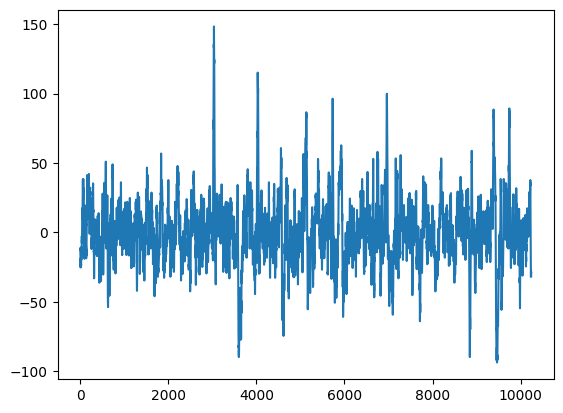

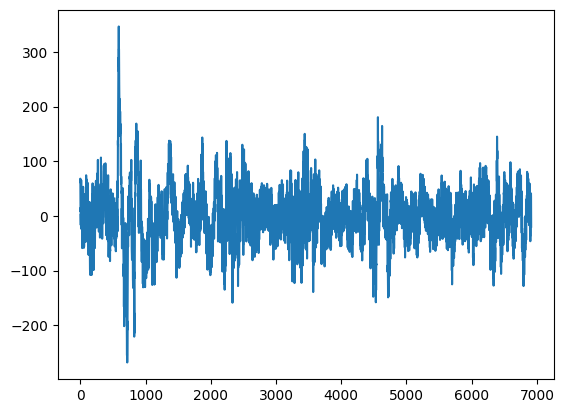

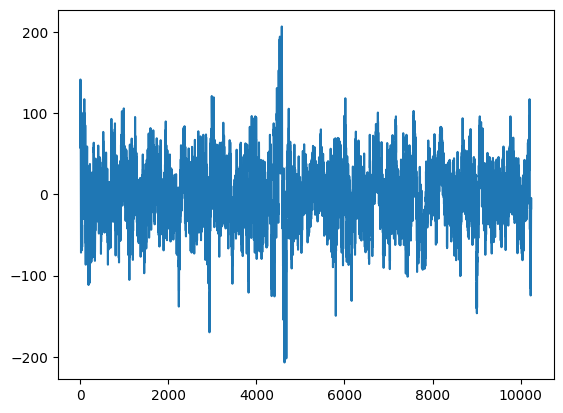

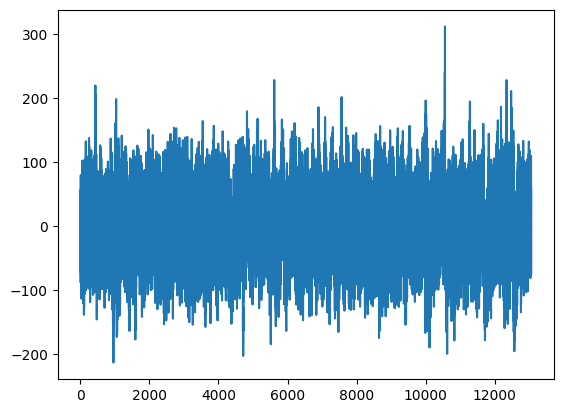

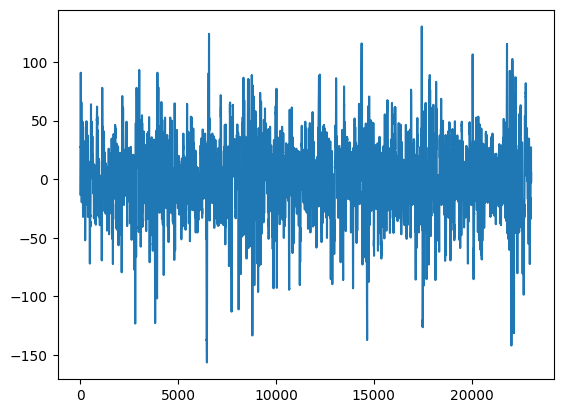

In [23]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

Getting seizure part of signal and labeling it with 5 * 256 window. We use 5 seconds window to label seizure part of signal and getting more data

In [24]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals, 
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(536, 2, 1280)

Plot some of seizure signals



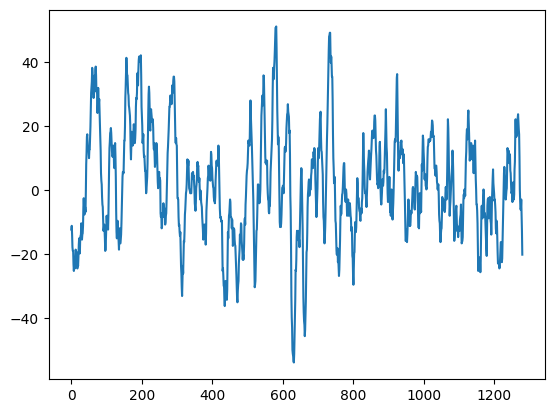

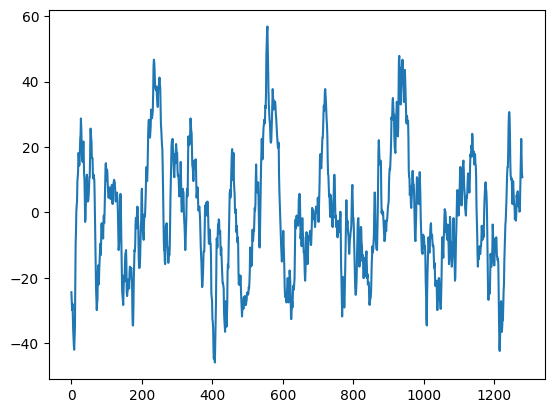

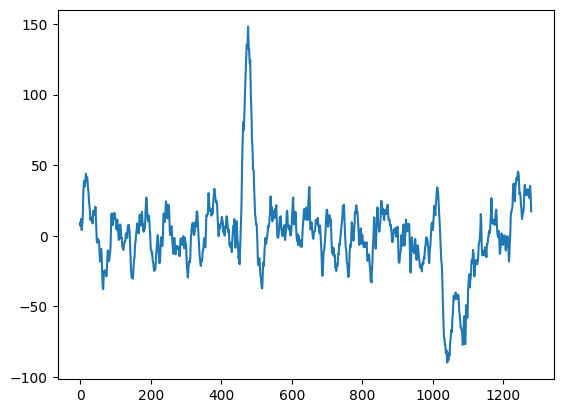

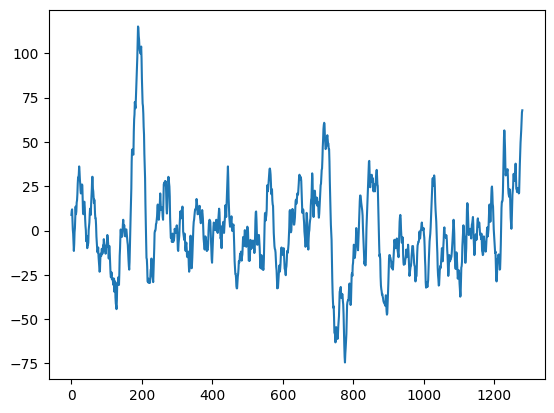

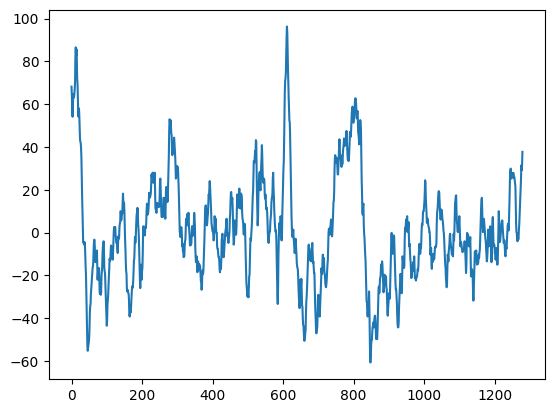

In [25]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Deleting first 5% & last 5% signals (noise)

In [26]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[i][0]))
        high_range = int(0.95*len(signals[i][0]))
        signals[i] = signals[i][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

len(signals_without_noise)

42

Removing the seizure part of each signal

In [28]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

len(signals_without_noise)

42

Getting non-seizure part of each signal & labeling each 5 * 256 random window

In [29]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals, 
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(3927, 2, 1280)

Plot non-seizure signals

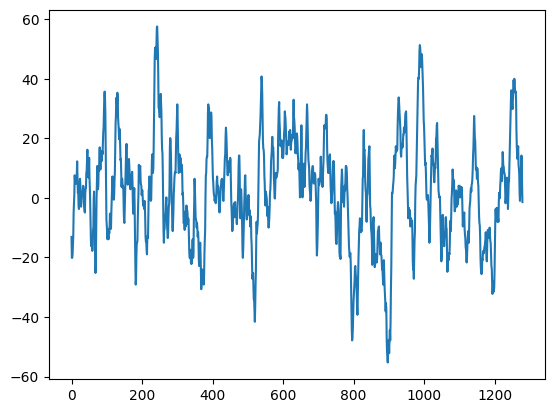

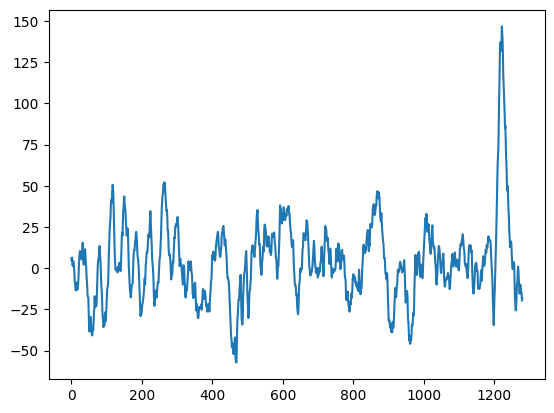

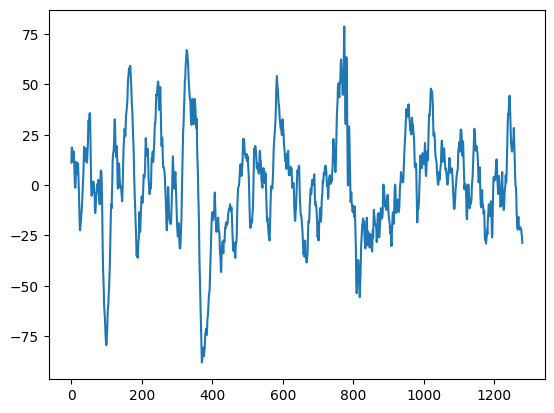

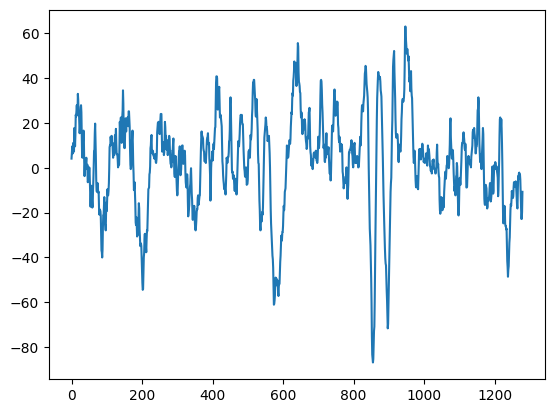

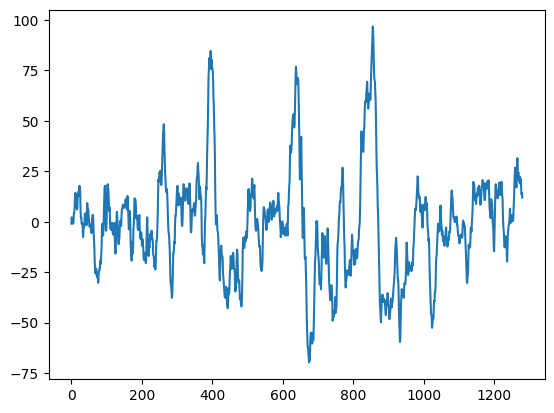

In [30]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Preparing final data

In [32]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [33]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(4463, 2, 1280) (4463,)


Plot some of each final signals

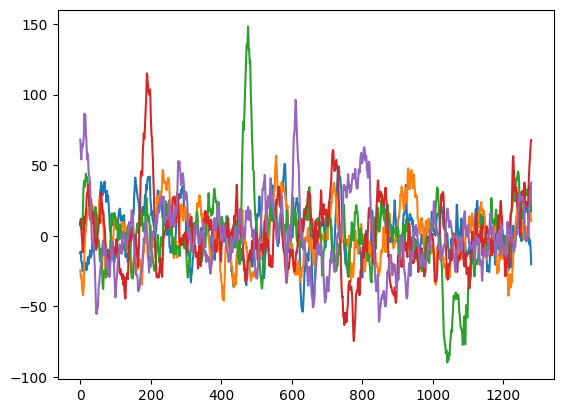

In [34]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()

Feature Extraction

* variance
* std
* mean
* fft
* fft2
* power
* power specular
* complexity
* zero crossing rate

In [37]:
def func_var(data):
    return np.var(data, axis=2)

def func_std(data):
    return np.std(data, axis=2)

def func_mean(data):
    return np.mean(data, axis=2)

def func_fft(data):
    return np.fft.fft(data, axis=2)

def func_fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def func_fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def func_fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def func_fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def func_fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def func_fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def func_power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def func_power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def func_zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

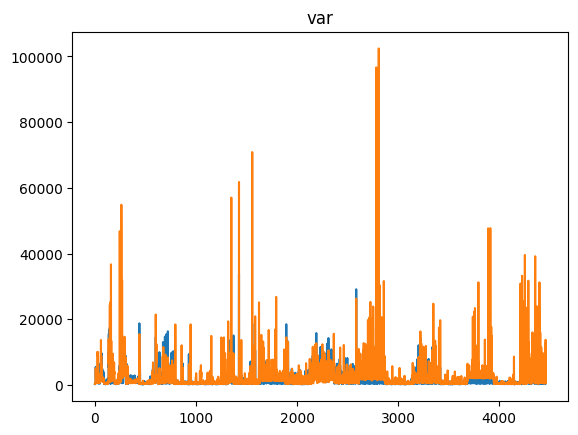

In [38]:
var = func_var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

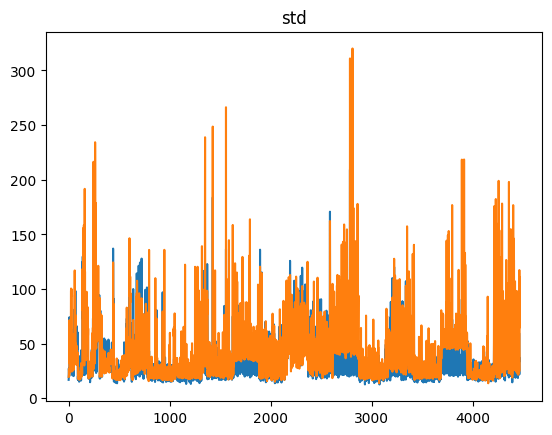

In [39]:
std = func_std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

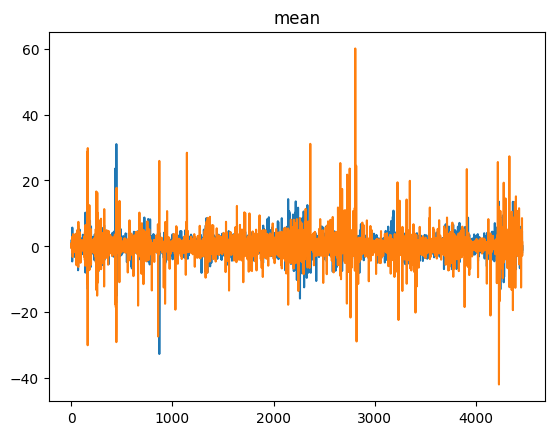

In [40]:
mean = func_mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()

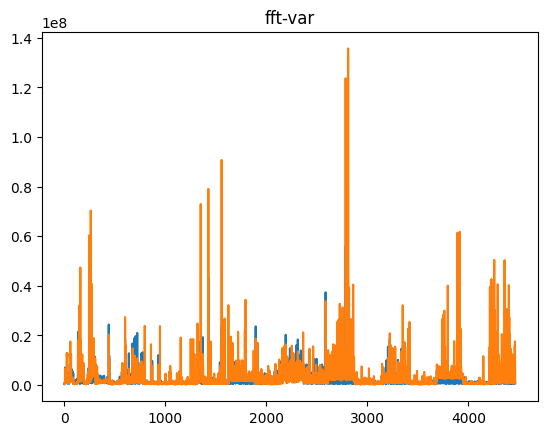

In [41]:
fft_var = func_fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()

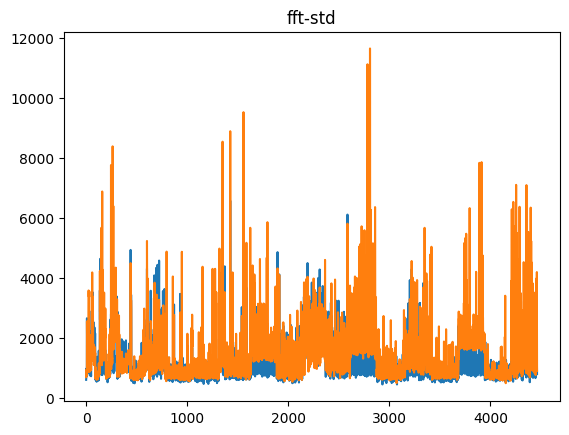

In [42]:
fft_std = func_fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


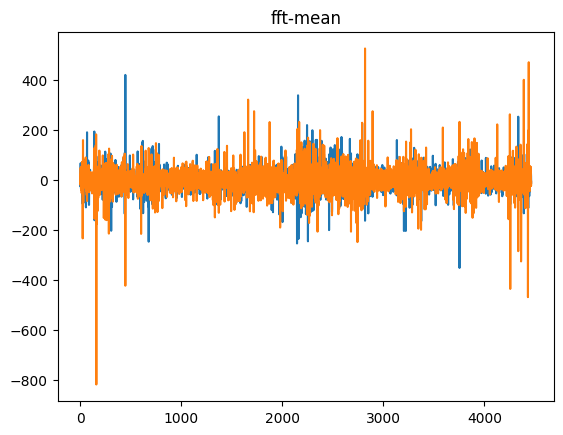

In [43]:
fft_mean = func_fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

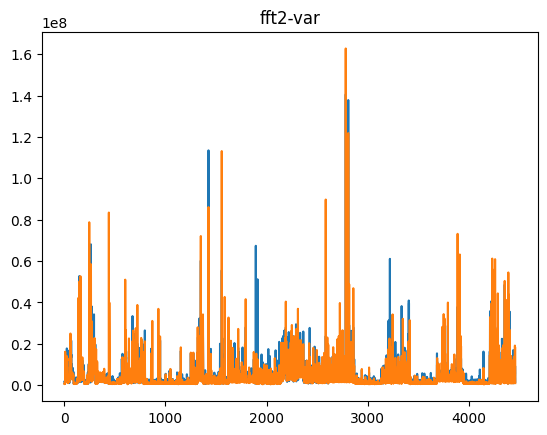

In [44]:
fft2_var = func_fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

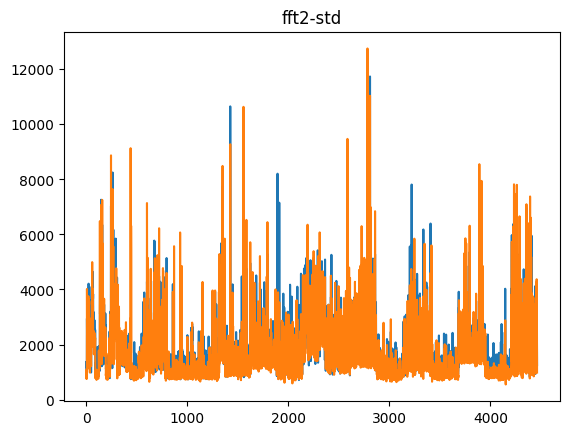

In [45]:
fft2_std = func_fft2_std(final_signals)

plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()

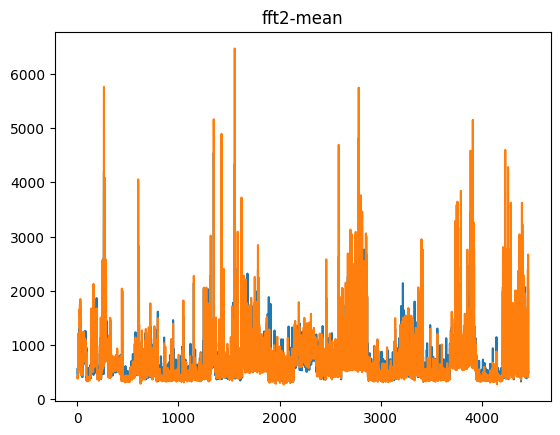

In [46]:

fft2_mean = func_fft2_mean(final_signals)

plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()

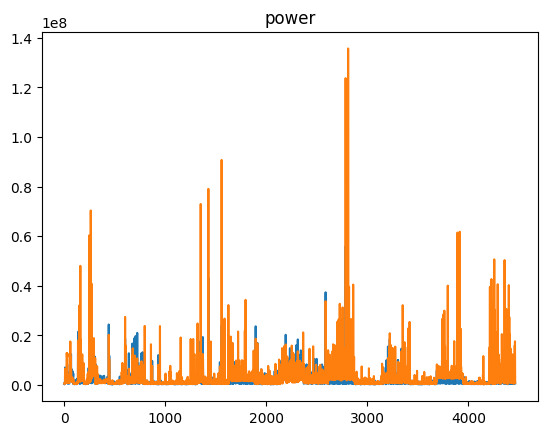

In [47]:
power = func_power(final_signals)

plt.title('power')
plt.plot(power)
plt.show()

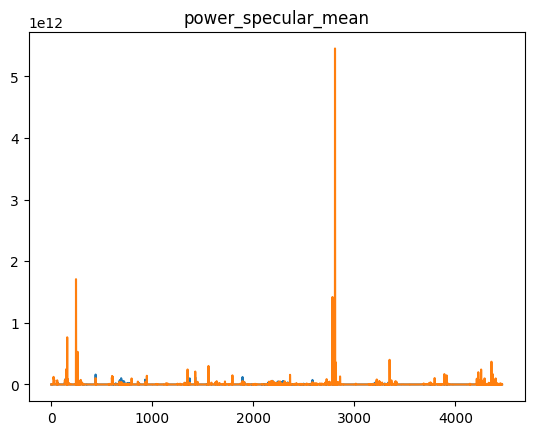

In [48]:
power_specular_mean = func_power_specular_mean(final_signals)

plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

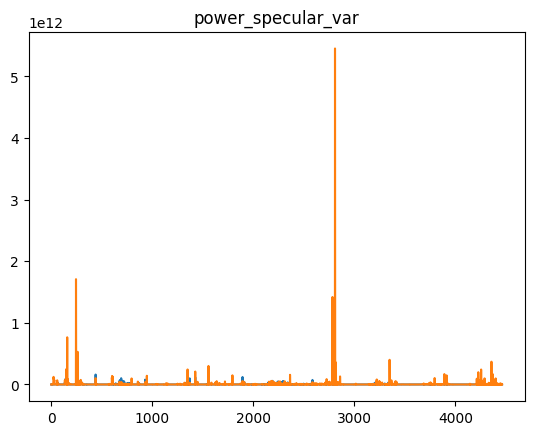

In [49]:
power_specular_var = func_power_specular_var(final_signals)

plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

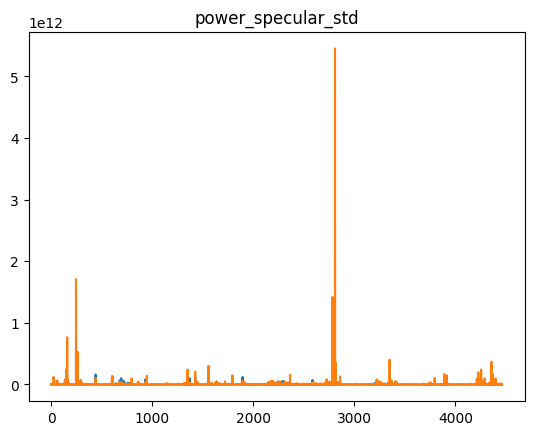

In [50]:
power_specular_std = func_power_specular_std(final_signals)

plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()

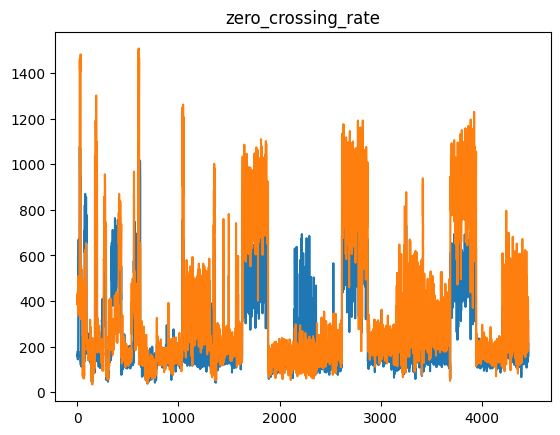

In [51]:
zero_crossing_rate = func_zero_crossing_rate(final_signals)

plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

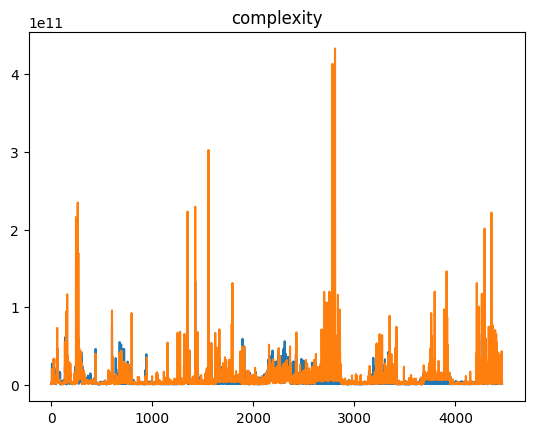

In [52]:
complexity = func_complexity(final_signals)

plt.title('complexity')
plt.plot(complexity)
plt.show()

Concatenating the features

In [53]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(4463, 28)

0.8734602463605823
[[780   0]
 [113   0]]


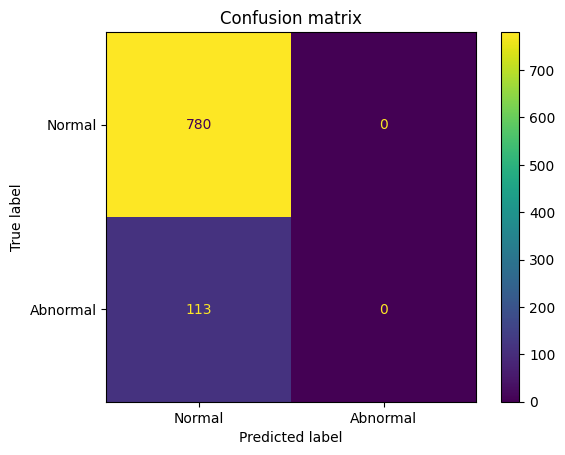

In [54]:
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

cm = confusion_matrix(y_test, y_prediction)

display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Abnormal'])
display.plot()
display.ax_.set_title('Confusion matrix')
plt.show()

In [56]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

CNN

A neural network with 3 convolutional layers, 3 max pooling and 2 fully connected layers.

* Kernel Size = Size of window
* Filter = Number of filter
* Dense Layer = Number of neurons
* Dropout Layer = Number of neurons in dropping level

In [57]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer
sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1276, 256)         2816      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 638, 256)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 638, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 317, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 317, 128)          0

In [59]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')

In [60]:
sequential.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
112/112 - 51s - loss: 2.2208 - accuracy: 0.8751 - 51s/epoch - 453ms/step
Epoch 2/10
112/112 - 48s - loss: 0.4227 - accuracy: 0.8818 - 48s/epoch - 431ms/step
Epoch 3/10
112/112 - 49s - loss: 0.3752 - accuracy: 0.8815 - 49s/epoch - 435ms/step
Epoch 4/10
112/112 - 49s - loss: 0.3652 - accuracy: 0.8815 - 49s/epoch - 435ms/step
Epoch 5/10
112/112 - 49s - loss: 0.3649 - accuracy: 0.8815 - 49s/epoch - 434ms/step
Epoch 6/10
112/112 - 49s - loss: 0.3646 - accuracy: 0.8812 - 49s/epoch - 438ms/step
Epoch 7/10
112/112 - 49s - loss: 0.3652 - accuracy: 0.8815 - 49s/epoch - 435ms/step
Epoch 8/10
112/112 - 49s - loss: 0.3638 - accuracy: 0.8815 - 49s/epoch - 435ms/step
Epoch 9/10
112/112 - 48s - loss: 0.3660 - accuracy: 0.8815 - 48s/epoch - 432ms/step
Epoch 10/10
112/112 - 49s - loss: 0.3652 - accuracy: 0.8818 - 49s/epoch - 437ms/step


In [61]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

28/28 - 3s - loss: 0.3802 - accuracy: 0.8735 - 3s/epoch - 111ms/step
CNN - Loss: 0.38023829460144043, Accuracy: 0.8734602332115173


In [62]:
y_prediction = sequential.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

28/28 [==============================] - 3s 96ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       780
           1       0.00      0.00      0.00       113

    accuracy                           0.87       893
   macro avg       0.44      0.50      0.47       893
weighted avg       0.76      0.87      0.81       893



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0, missing rate: 1.0


In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

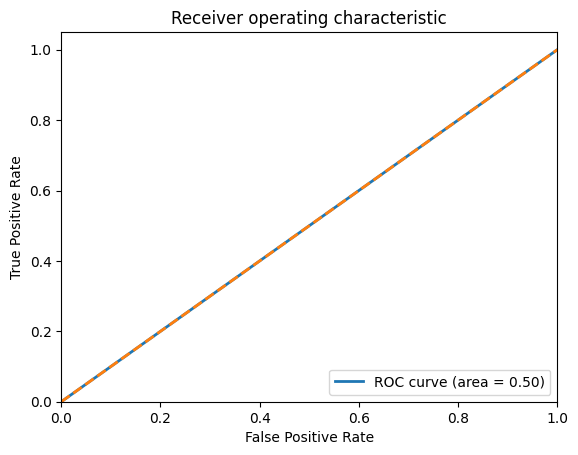

In [65]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [66]:
LEARNING_RATE = 0.01

sequential_b = Sequential()
sequential_b.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential_b.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential_b.add(BatchNormalization())
sequential_b.add(Conv1D(filters=FILTER_SIZE / 2
                ,kernel_size=KERNEL_SIZE
                ,activation='relu'
                ,input_shape=(WINDOW_SIZE, 2)))

sequential_b.add(Flatten())

sequential_b.add(Dense(features.shape[1], activation='relu'))
sequential_b.add(Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

sequential_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sequential_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1276, 256)         2816      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 638, 256)         0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 638, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_4 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 flatten_1 (Flatten)         (None, 81152)             0         
                                                                 
 dense_2 (Dense)             (None, 28)               

In [67]:
sequential_b.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
112/112 - 44s - loss: 0.9468 - accuracy: 0.8782 - 44s/epoch - 391ms/step
Epoch 2/10
112/112 - 42s - loss: 0.5886 - accuracy: 0.8815 - 42s/epoch - 377ms/step
Epoch 3/10
112/112 - 43s - loss: 0.5339 - accuracy: 0.8815 - 43s/epoch - 381ms/step
Epoch 4/10
112/112 - 43s - loss: 0.4919 - accuracy: 0.8815 - 43s/epoch - 387ms/step
Epoch 5/10
112/112 - 44s - loss: 0.4597 - accuracy: 0.8815 - 44s/epoch - 388ms/step
Epoch 6/10
112/112 - 44s - loss: 0.4352 - accuracy: 0.8815 - 44s/epoch - 392ms/step
Epoch 7/10
112/112 - 43s - loss: 0.4167 - accuracy: 0.8815 - 43s/epoch - 382ms/step
Epoch 8/10
112/112 - 43s - loss: 0.4028 - accuracy: 0.8815 - 43s/epoch - 380ms/step
Epoch 9/10
112/112 - 43s - loss: 0.3923 - accuracy: 0.8815 - 43s/epoch - 382ms/step
Epoch 10/10
112/112 - 43s - loss: 0.3846 - accuracy: 0.8815 - 43s/epoch - 380ms/step


In [68]:
model_loss, model_accuracy = sequential_b.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

28/28 - 3s - loss: 0.3931 - accuracy: 0.8735 - 3s/epoch - 106ms/step
CNN - Loss: 0.3930836319923401, Accuracy: 0.8734602332115173


In [70]:
y_prediction = sequential_b.predict(x_test)
sequential_b.save('/kaggle/woring/model.h5')
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

28/28 [==============================] - 3s 90ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       780
           1       0.00      0.00      0.00       113

    accuracy                           0.87       893
   macro avg       0.44      0.50      0.47       893
weighted avg       0.76      0.87      0.81       893



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0, missing rate: 1.0


In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

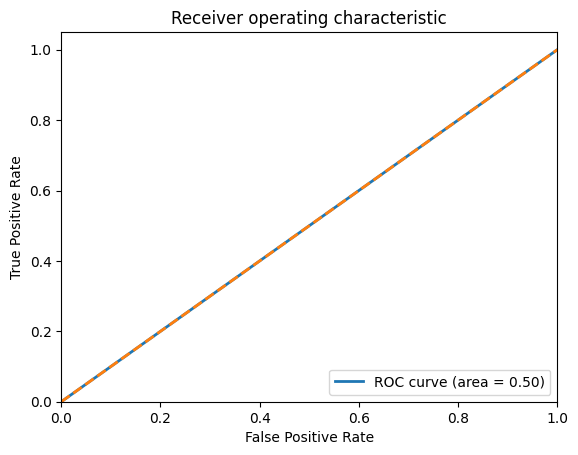

In [73]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()